<a href="https://colab.research.google.com/github/m-pydych/Beans_ML/blob/main/beans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BEANS**

# Příprava dat

### Stažení dat a importy


In [ ]:
# data: https://github.com/AI-Lab-Makerere/ibean/?tab=readme-ov-file

# Dataset download and extract
!wget -q --show-progress -O train.zip https://storage.googleapis.com/ibeans/train.zip
!wget -q --show-progress -O validation.zip https://storage.googleapis.com/ibeans/validation.zip
!wget -q --show-progress -O test.zip https://storage.googleapis.com/ibeans/test.zip

!unzip -q -o train.zip
!unzip -q -o validation.zip
!unzip -q -o test.zip
print("\nunzip done")

train.zip           100%[===================>] 137.15M  16.1MB/s    in 10s     
validation.zip      100%[===================>]  17.65M  6.79MB/s    in 2.6s    
test.zip            100%[===================>]  16.89M  6.46MB/s    in 2.6s    

unzip done


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

import torchvision
from torchvision import transforms, datasets, models

import os
import time
import copy
import random
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Definice funkcí pro představení dat a preprocesing (boring)


In [ ]:
def show_random_leaf_examples(root_path='train'):
    classes = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])

    plt.figure(figsize=(15, 5))

    for i, cls in enumerate(classes):
        class_path = os.path.join(root_path, cls)

        all_images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        random_file = random.choice(all_images)
        img_path = os.path.join(class_path, random_file)

        img = Image.open(img_path)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(cls, fontsize=12, fontweight='bold')
        plt.axis('off')

    plt.suptitle("Ukázky listů z jednotlivých kategorií", fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

def get_folder_counts(root_path):
    if not os.path.exists(root_path): return {}
    classes = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    return {cls: len([f for f in os.listdir(os.path.join(root_path, cls)) if os.path.isfile(os.path.join(root_path, cls, f))]) for cls in classes}

def print_graph_1():
    raw_counts = {
        'Train': get_folder_counts('train'),
        'Validation': get_folder_counts('validation'),
        'Test': get_folder_counts('test')
    }

    plot_data = []
    for split, classes in raw_counts.items():
        for cls_name, count in classes.items():
            plot_data.append({'Split': split, 'Třída': cls_name, 'Počet obrázků': count})

    df_plot = pd.DataFrame(plot_data)

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    ax = sns.barplot(data=df_plot, x='Split', y='Počet obrázků', hue='Třída', palette='magma')

    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha = 'center', va = 'center',
                        xytext = (0, 9),
                        textcoords = 'offset points',
                        fontsize=10)

    plt.title('Počty obrázků v jednotlivých setech', fontsize=14, pad=20)
    plt.ylabel('Počet obrázků', fontsize=12)
    plt.xlabel('Dataset Set', fontsize=12)
    plt.ylim(0, max(df_plot['Počet obrázků']) * 1.15)
    plt.legend(title='Třída (Choroba)')
    plt.show()


In [ ]:
def show_augmented_variants(base_ds, aug1_ds, aug2_ds, aug3_ds):
    idx = random.randint(0, len(base_ds) - 1)

    img0, label = base_ds[idx]
    img1, _ = aug1_ds[idx]
    img2, _ = aug2_ds[idx]
    img3, _ = aug3_ds[idx]

    images = [img0, img1, img2, img3]
    titles = [
        "Původní (Base)",
        "Aug 1 (Crop + Flip)",
        "Aug 2 (Rot + Color)",
        "Aug 3 (Kombinace)"
    ]

    class_name = base_ds.classes[label]

    def denormalize(tensor):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])

        img = tensor.permute(1, 2, 0).cpu().numpy()
        img = std * img + mean
        img = np.clip(img, 0, 1)
        return img

    plt.figure(figsize=(20, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(denormalize(images[i]))
        plt.title(f"{titles[i]}\nTřída: {class_name}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### Představení dat a popis řešené úlohy

Úloha spočívá v natrénování neuronové sítě pro rozpoznávání nemocných a zdravých rostlin fazol z fotek listů. Nemoci jsou v datasetu dvě. Dataset tudíž obsahuje tyto třídy:
*   Angular leaf spot - běžné bakteriální onemocnění
*   Bean rust - běžné houbové onemocnění
*   Healthy - zdravá rostlina

Dataset byl už u zdoje rozelený na trénovcací, testovací a validační sadu. Následuje graf četnosti tříd v jednotlivých sadách, a ukázky fotek listů.

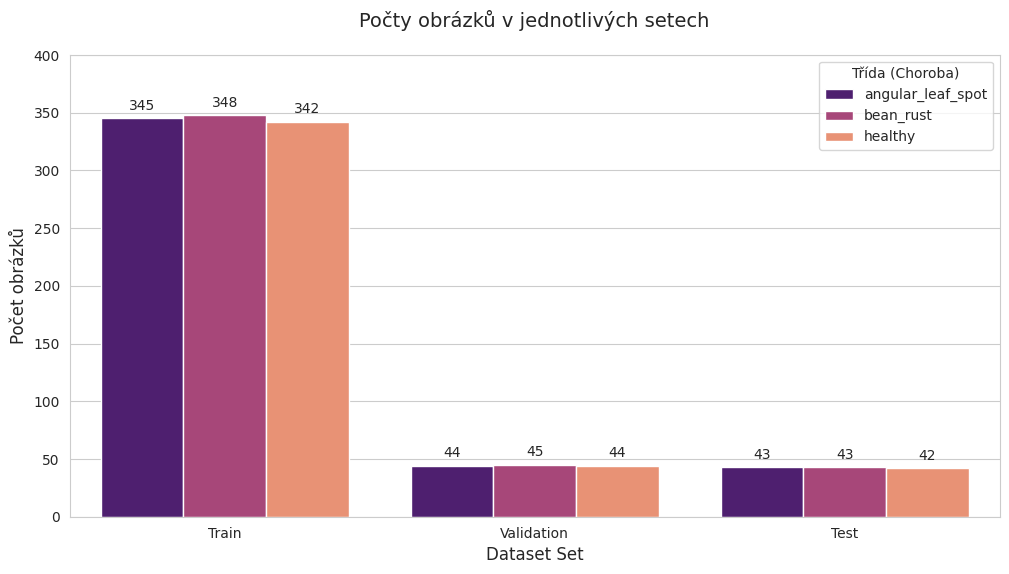

In [ ]:
print_graph_1()

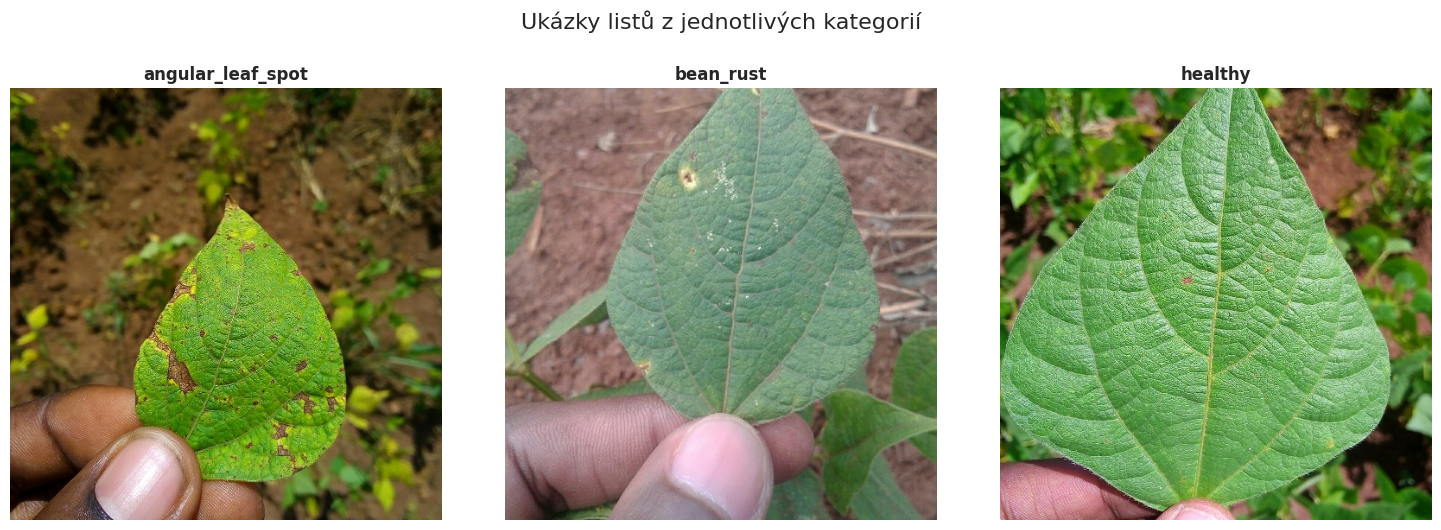

In [ ]:
show_random_leaf_examples() # mužete pustit znovu, dá to vždy jiné

### Preprocesing

*   Vzhledem k tomu že trénovací sada obsahuje v základu jen 1035 obrázků, od začátku byl velký problém overfiting. Už u prvních pokusů se ukazovalo že se model vždy velice rychle naučil trénovací sadu nazpaměť včetně všeho šumu, a moc se mu nedařilo generalizovat.

*   Z toho důvodu jsem zavedl rozsáhlou augmentaci datasetu, která trénovací sadu rošíří na čtyřnásobek původní velikosti.

*   Augmentace obsahuje čtyři transformace, kde se ke každému obrázku z původní sady vytvoří tři další varianty:

      1.    base_transform provádí jen uplně základní transformaci, která provede downscale z 500x500 na 224x224 (kvůli matematickým výhodám i transfer learning modelu), a normalizuje hodnoty barev kolem standartně používaných hodnot: ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) - hodnoty z datasetu ImageNet

      2.    transform_1 před downscalem si algoritmus z obrázku vybere náhodný obdelník v poměru stran od 4:3 do 3:4, který zabírá 70-100% obrázku. Tuto vybranou oblast následně roztáhne nebo zploští na poměr 1:1 a změní rozlišení na pevných 224x224. Poté se obrázek ještě horizontálně překlopí a barvy se opět normalizují podle ImageNet standardu.

      3.    transform_2 obrázek náhodně otočí o -20 až 20 stupňů, náhodně lehce změní jas a kontrast a provede downscale a ImageNet normalizaci.

      4.    transform_1_and_2 provede transformace z dvou předchozích bodů najednou.

*   výsledkem jsou celkem 4 varianty jednoho původního obrázku. Velikost trénovacího datasetu se zvětší na 4140 z původních 1035.
*   
Původně jsem zkoušel tyto transformace dělat až po převedení všeho na 224x224, což přinášelo horší výsledky, pravděpodobně kvůli ztrátě dat.

In [ ]:
# DEFINIG TRANSFORMATIONS
# Base transformation for validation and test data (+ original train data)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Crop + Flip
transform_1 = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Rotation + Color
transform_2 = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.25, contrast=0.25),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Crop + Flip + Rotation + Color
transform_1_and_2 = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.25, contrast=0.25),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# APPLY TRANSFORMATION
val_dataset = datasets.ImageFolder(root='validation', transform=base_transform)
test_dataset = datasets.ImageFolder(root='test', transform=base_transform)

train_base = datasets.ImageFolder(root='train', transform=base_transform)
train_aug1 = datasets.ImageFolder(root='train', transform=transform_1)
train_aug2 = datasets.ImageFolder(root='train', transform=transform_2)
train_aug3 = datasets.ImageFolder(root='train', transform=transform_1_and_2)

# Merge base train data with augmented data
train_dataset = ConcatDataset([train_base, train_aug1, train_aug2, train_aug3])

# DATALOADERS
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

base_train_loader = DataLoader(train_base, batch_size=batch_size, shuffle=True)



print(f"Počet trénovacích vzorků (po expanzi): {len(train_dataset)}")
print(f"train classes: {train_base.classes}")
print(f"  val classes: {val_dataset.classes}")
print(f" test classes: {test_dataset.classes}")

Počet trénovacích vzorků (po expanzi): 4136
train classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
  val classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
 test classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


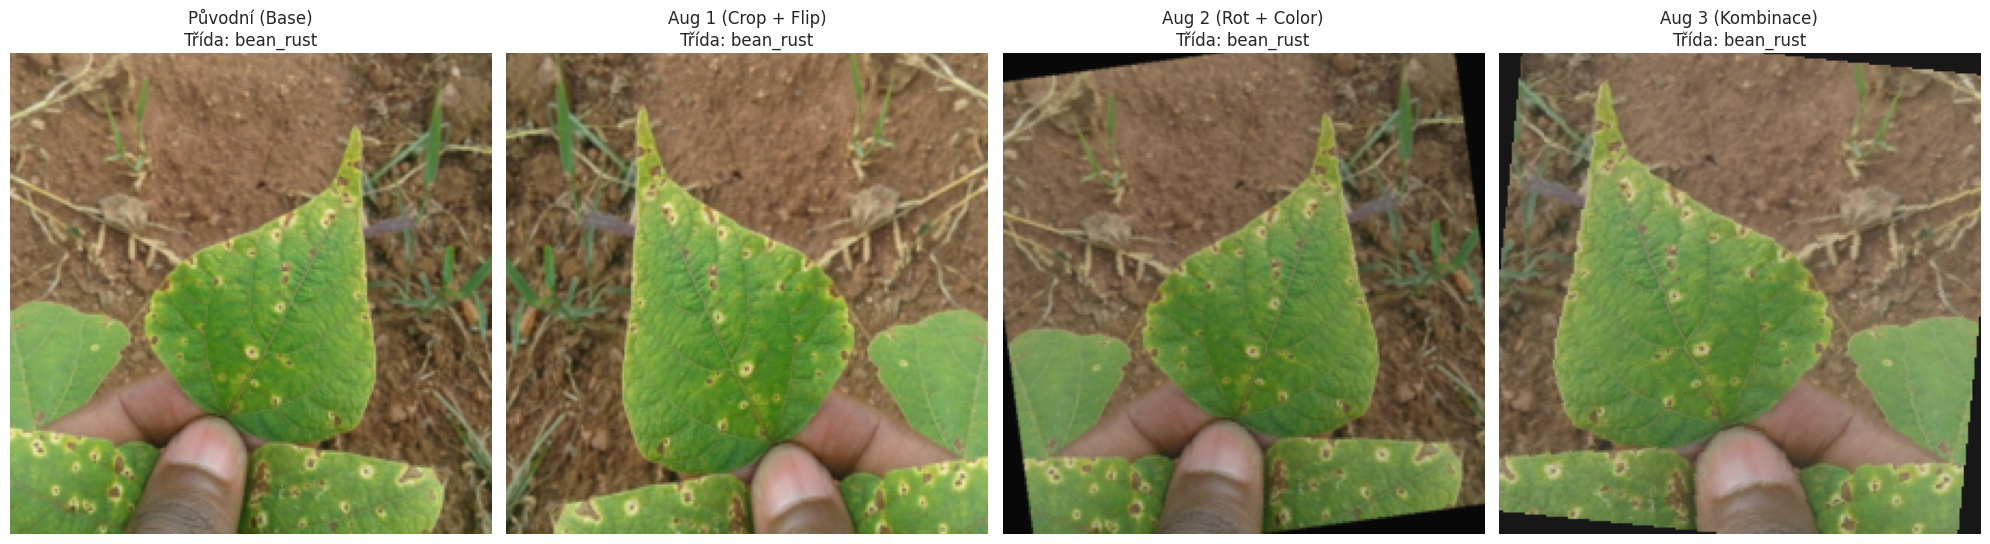

In [ ]:
# příklad variant pro jeden náhodný obrázek
show_augmented_variants(train_base, train_aug1, train_aug2, train_aug3)

# Modelování

### Definice funkce pro trénování

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, epochs=10, lr=0.001, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    best_epoch = 0
    best_train_acc = 0
    best_val_acc = 0

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100. * correct / total
        val_acc = 100. * val_correct / val_total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epocha {epoch+1}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            best_epoch = epoch + 1
            best_train_acc = train_acc
            best_val_acc = val_acc
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping aktivován po {epoch+1} epochách.")
            break

    model.load_state_dict(best_model_wts)

    print(f"Nejlepší epocha {best_epoch}: Train Acc: {best_train_acc:.2f}% | Val Acc: {best_val_acc:.2f}% | Val Loss: {best_val_loss:.4f}")

    print(f"\nDoba trénování: {time.time() - start_time:.2f} s")
    return history


# history_x = train_and_evaluate(model_x, train_loader, val_loader, epochs=15, patience=3)

## Definice jednotlivých modelů

### Baseline

základní model bez použití pokročilejších technik

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


---

### Pokročilejší model

model rozšířený o regularizační techniky

In [ ]:
class RegularizedCNN(nn.Module):
    def __init__(self):
        super(RegularizedCNN, self).__init__()
        #  224x224 -> 112x112
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # 112x112 -> 56x56
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # 56x56 -> 28x28
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # 28x28 -> 14x14
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        # Clasification
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 256 * 14 * 14)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x


---

### Předtrénovaný model - resnet18

In [ ]:
model_3 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model_3.parameters():
    param.requires_grad = False

num_ftrs = model_3.fc.in_features
model_3.fc = nn.Linear(num_ftrs, 3)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


# Trénink

Pro trénink jsem ke třem původním modelům přidal ještě jednu variaci toho prvního nejjednoduššího, která je trénovaná na původních datech bez augmentace. Přišlo mi to jako dobrý krok pro zobrazení zlepšení po dobrém preprocesingu.

In [ ]:
model_0 = SimpleCNN().to(device)
history_0 = train_and_evaluate(model_0, base_train_loader, val_loader, epochs=15, patience=3)
# Baseline model trénovaný na trénovacích datech bez nově vytvořených

Epocha 1: Train Acc: 41.68% | Val Acc: 56.39% | Val Loss: 0.9188
Epocha 2: Train Acc: 61.51% | Val Acc: 70.68% | Val Loss: 0.6180
Epocha 3: Train Acc: 75.44% | Val Acc: 71.43% | Val Loss: 0.6099
Epocha 4: Train Acc: 83.46% | Val Acc: 70.68% | Val Loss: 0.6010
Epocha 5: Train Acc: 87.33% | Val Acc: 74.44% | Val Loss: 0.6891
Epocha 6: Train Acc: 93.52% | Val Acc: 76.69% | Val Loss: 0.5845
Epocha 7: Train Acc: 97.68% | Val Acc: 77.44% | Val Loss: 0.7235
Epocha 8: Train Acc: 99.32% | Val Acc: 80.45% | Val Loss: 0.6377
Epocha 9: Train Acc: 100.00% | Val Acc: 81.20% | Val Loss: 0.6802

Early stopping aktivován po 9 epochách.
Nejlepší epocha 6: Train Acc: 93.52% | Val Acc: 76.69% | Val Loss: 0.5845

Doba trénování: 72.77 s


In [ ]:
model_1 = SimpleCNN().to(device)
history_1 = train_and_evaluate(model_1, train_loader, val_loader, epochs=15, patience=3)

Epocha 1: Train Acc: 64.72% | Val Acc: 69.17% | Val Loss: 0.5670
Epocha 2: Train Acc: 74.73% | Val Acc: 69.92% | Val Loss: 0.4894
Epocha 3: Train Acc: 78.84% | Val Acc: 75.94% | Val Loss: 0.4580
Epocha 4: Train Acc: 83.39% | Val Acc: 81.20% | Val Loss: 0.3927
Epocha 5: Train Acc: 86.58% | Val Acc: 82.71% | Val Loss: 0.3226
Epocha 6: Train Acc: 89.53% | Val Acc: 84.96% | Val Loss: 0.3162
Epocha 7: Train Acc: 90.93% | Val Acc: 85.71% | Val Loss: 0.3082
Epocha 8: Train Acc: 91.54% | Val Acc: 81.95% | Val Loss: 0.3514
Epocha 9: Train Acc: 93.18% | Val Acc: 84.96% | Val Loss: 0.3629
Epocha 10: Train Acc: 94.22% | Val Acc: 83.46% | Val Loss: 0.3316

Early stopping aktivován po 10 epochách.
Nejlepší epocha 7: Train Acc: 90.93% | Val Acc: 85.71% | Val Loss: 0.3082

Doba trénování: 396.81 s


In [ ]:
model_2 = RegularizedCNN().to(device)
history_2 = train_and_evaluate(model_2, train_loader, val_loader, epochs=15, patience=3)

Epocha 1: Train Acc: 61.99% | Val Acc: 75.19% | Val Loss: 0.5843
Epocha 2: Train Acc: 74.06% | Val Acc: 78.95% | Val Loss: 0.5253
Epocha 3: Train Acc: 77.08% | Val Acc: 78.95% | Val Loss: 0.4149
Epocha 4: Train Acc: 79.33% | Val Acc: 81.95% | Val Loss: 0.4171
Epocha 5: Train Acc: 82.59% | Val Acc: 86.47% | Val Loss: 0.2973
Epocha 6: Train Acc: 86.27% | Val Acc: 87.97% | Val Loss: 0.3064
Epocha 7: Train Acc: 88.83% | Val Acc: 78.20% | Val Loss: 0.6246
Epocha 8: Train Acc: 89.89% | Val Acc: 90.98% | Val Loss: 0.2979

Early stopping aktivován po 8 epochách.
Nejlepší epocha 5: Train Acc: 82.59% | Val Acc: 86.47% | Val Loss: 0.2973

Doba trénování: 377.36 s


In [ ]:
model_3 = model_3.to(device)
history_3 = train_and_evaluate(model_3, train_loader, val_loader, epochs=15, patience=3)

Epocha 1: Train Acc: 71.71% | Val Acc: 84.96% | Val Loss: 0.4529
Epocha 2: Train Acc: 84.86% | Val Acc: 88.72% | Val Loss: 0.3239
Epocha 3: Train Acc: 87.14% | Val Acc: 89.47% | Val Loss: 0.2493
Epocha 4: Train Acc: 88.39% | Val Acc: 92.48% | Val Loss: 0.2084
Epocha 5: Train Acc: 88.18% | Val Acc: 93.23% | Val Loss: 0.1903
Epocha 6: Train Acc: 88.08% | Val Acc: 90.98% | Val Loss: 0.2067
Epocha 7: Train Acc: 89.89% | Val Acc: 92.48% | Val Loss: 0.1808
Epocha 8: Train Acc: 89.65% | Val Acc: 92.48% | Val Loss: 0.1688
Epocha 9: Train Acc: 90.88% | Val Acc: 93.23% | Val Loss: 0.1611
Epocha 10: Train Acc: 90.47% | Val Acc: 92.48% | Val Loss: 0.1562
Epocha 11: Train Acc: 90.69% | Val Acc: 93.98% | Val Loss: 0.1621
Epocha 12: Train Acc: 90.81% | Val Acc: 93.23% | Val Loss: 0.1595
Epocha 13: Train Acc: 90.72% | Val Acc: 92.48% | Val Loss: 0.1544
Epocha 14: Train Acc: 89.82% | Val Acc: 92.48% | Val Loss: 0.1503
Epocha 15: Train Acc: 91.34% | Val Acc: 92.48% | Val Loss: 0.1573
Nejlepší epocha 14:

## hyperparameter tuning log



*   Epochy - původně bylo nastaveno 8, a pak 10, často se ale stávalo že byla nejlepší ta poslední, tak jsem všem modelům nastavil early stopping a maximální počet epoch 15, aby se to zastavilo pokud se nedetekuje zlepšení.
*   Patience - zkoušel jsem 5 a 4, nakonec jsem skončil u 3. Většinou trening probíhal dvěma způsoby:

    1.   buď se model postupně stabilně zlepšoval, a tudíž ho nižší early stopping nezastavil

    2.   Nebo model nestabilně skákal z velkých hodnot na malé, a skončil u poslední epochy s velice podobnou hodnotou loss jako byla měly epochy zezačátku.
            
MODEL_2:
*   Dropout - (u druhého modelu) byl původně nastaven na 0.5, což se ukázalo jako přemrštěná hodnota, protože model několikrát dopadnul hůř než ten uplně jednoduchý první model
*   Aktivační fce - změna z relu na leaky relu






# Evaluace

### Definice funkcí pro evaluaci (boring)

In [ ]:
def evaluate_final(model, loader, device):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (100 * correct / total), (total_loss / len(loader))

def arch_vAc_tAc_tLoss_table():
    results = []
    models = [
        (model_0, history_0, "Model 0"),
        (model_1, history_1, "Model 1"),
        (model_2, history_2, "Model 2"),
        (model_3, history_3, "Model 3")
    ]

    for model, history, name in models:
        best_val_acc = max(history['val_acc'])

        test_acc, test_loss = evaluate_final(model, test_loader, device)

        results.append({
            'Architektura': name,
            'Val. Accuracy (%)': round(best_val_acc, 2),
            'Test Accuracy (%)': round(test_acc, 2),
            'Test Loss': round(test_loss, 4)
        })

    df_results = pd.DataFrame(results)
    display(df_results)

# arch_vAc_tAc_tLoss_table()


In [ ]:
def compare_models():
    models_data = {
        'Model 0 (Základní)': history_0,
        'Model 1 (Augmentace)': history_1,
        'Model 2 (Regulace)': history_2,
        'Model 3 (Transfer L.)': history_3
    }

    comparison_list = []

    for name, hist in models_data.items():
        comparison_list.append({
            'Model': name,
            'Max Val Acc (%)': max(hist['val_acc']),
            'Min Val Loss': min(hist['val_loss']),
            'Epochy': len(hist['val_acc'])
        })

    df_comparison = pd.DataFrame(comparison_list)

    print("SROVNÁNÍ VÝKONNOSTI MODELŮ:")
    display(df_comparison)

    plt.figure(figsize=(12, 6))

    for name, hist in models_data.items():
        plt.plot(hist['val_acc'], label=f'{name} (max: {max(hist["val_acc"]):.2f}%)')

    plt.title('Srovnání přesnosti modelů na validačních datech')
    plt.xlabel('Epocha')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(12, 6))

    for name, hist in models_data.items():
        plt.plot(hist['val_loss'], label=f'{name} (min: {min(hist["val_loss"]):.4f})')

    plt.title('Srovnání ztráty (Loss) modelů na validačních datech')
    plt.xlabel('Epocha')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# compare_models()

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Vývoj přesnosti (Accuracy)')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Vývoj ztráty (Loss)')
    plt.legend()

    plt.show()

# plot_history(history_x)

In [ ]:
def plot_confusion_matrix(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=loader.dataset.classes,
                yticklabels=loader.dataset.classes)
    plt.xlabel('Predikované')
    plt.ylabel('Skutečné')
    plt.title('Matice záměn (Confusion Matrix)')
    plt.show()

# plot_confusion_matrix(model_x, test_loader)

### Vizualizace výsledů

In [ ]:
arch_vAc_tAc_tLoss_table()

,Architektura,Val. Accuracy (%),Test Accuracy (%),Test Loss
0,Model 0,81.20,77.34,0.5775
1,Model 1,85.71,87.50,0.2807
2,Model 2,90.98,83.59,0.3579
3,Model 3,93.98,87.50,0.2820


SROVNÁNÍ VÝKONNOSTI MODELŮ:


,Model,Max Val Acc (%),Min Val Loss,Epochy
0,Model 0 (Základní),81.203008,0.584488,9
1,Model 1 (Augmentace),85.714286,0.308213,10
2,Model 2 (Regulace),90.977444,0.297327,8
3,Model 3 (Transfer L.),93.984962,0.150254,15


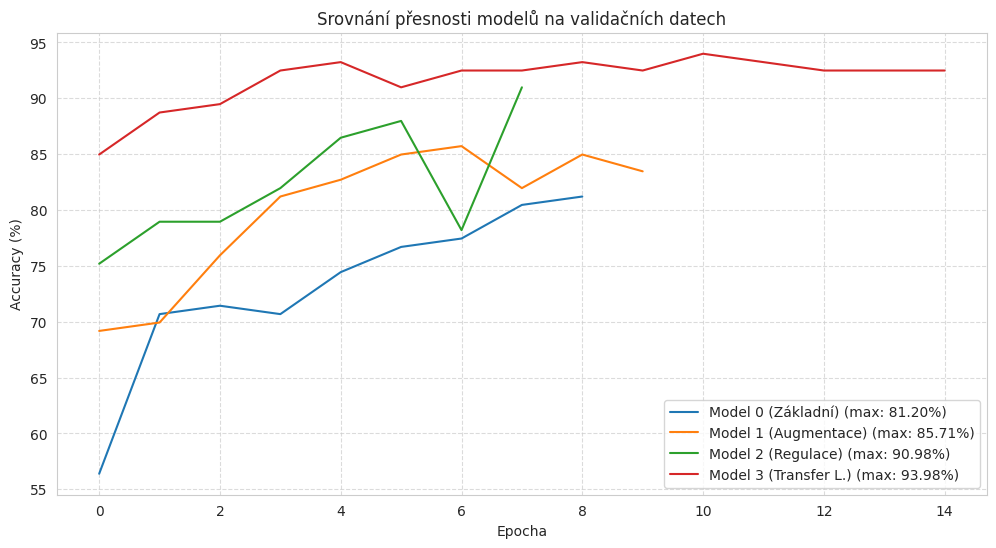

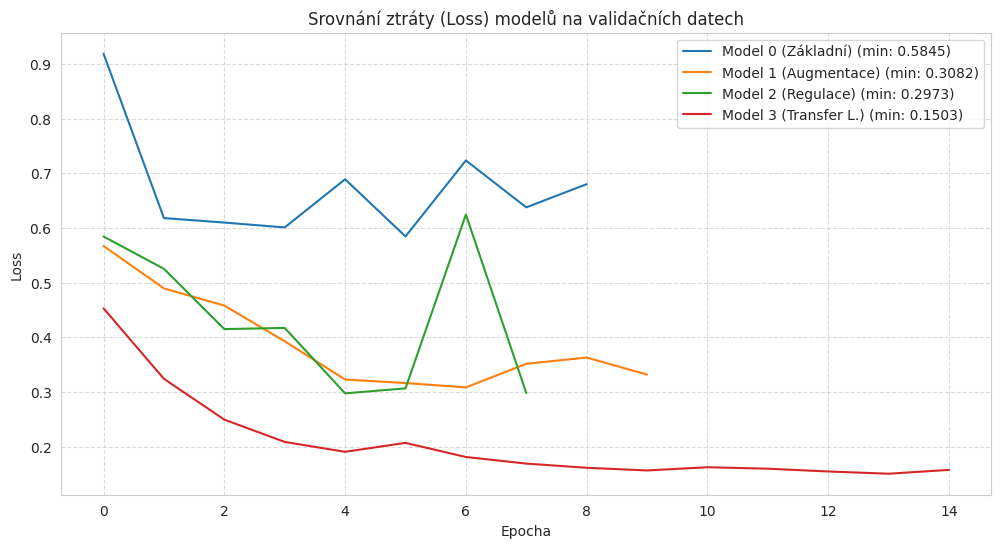

In [ ]:
compare_models()

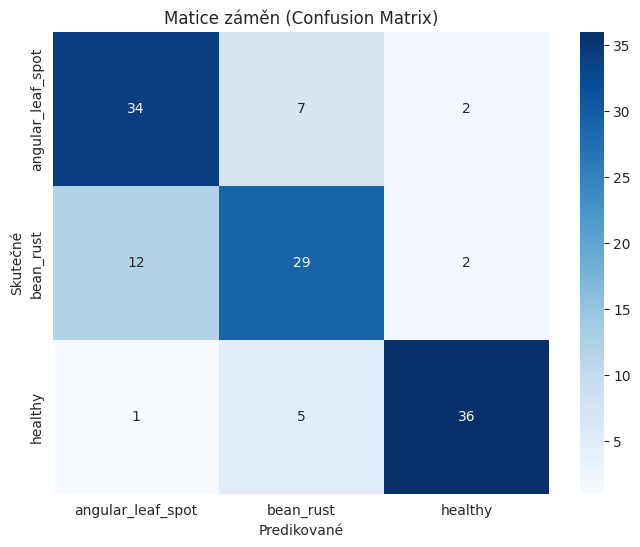

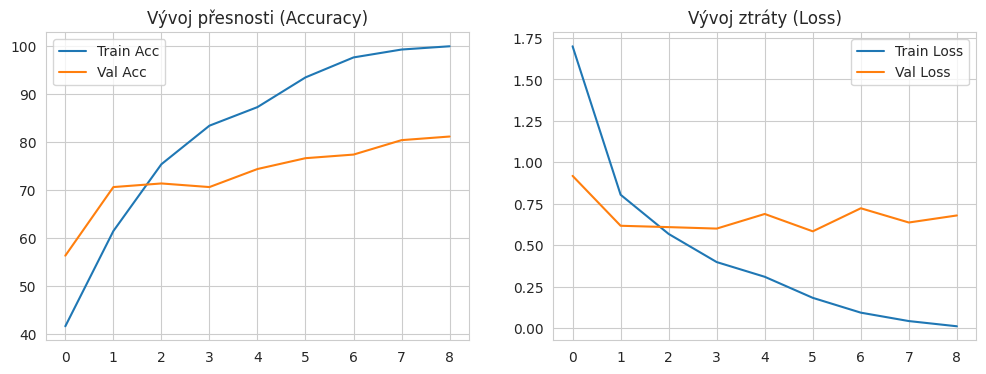

In [ ]:
# jenom base model
plot_confusion_matrix(model_0, test_loader)
plot_history(history_0)

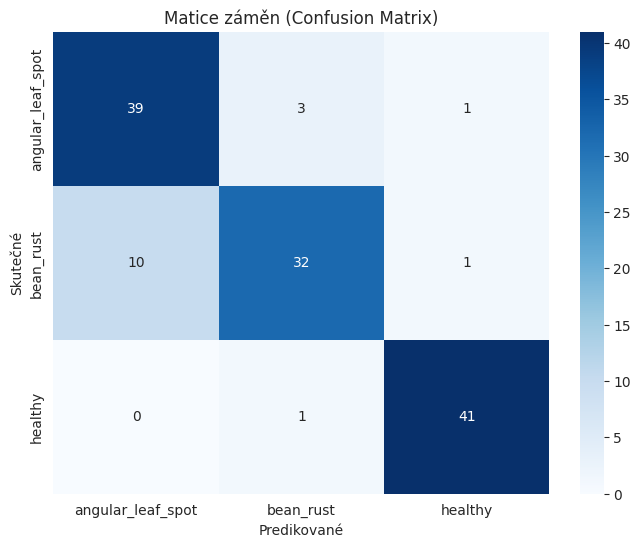

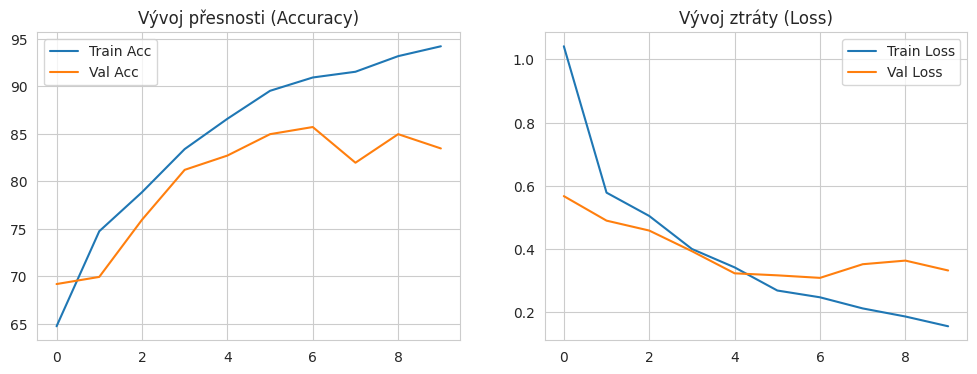

In [ ]:
# preprocesing + base model
plot_confusion_matrix(model_1, test_loader)
plot_history(history_1)

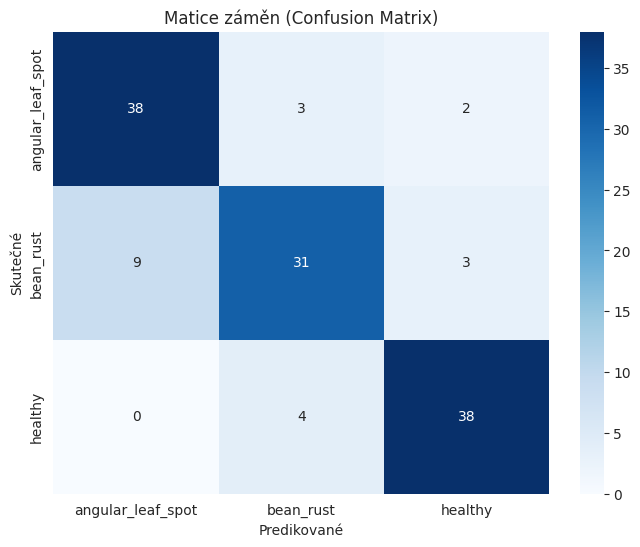

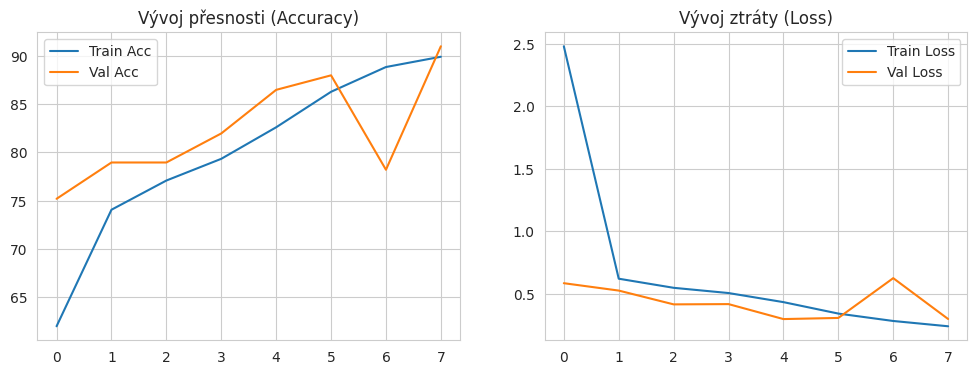

In [ ]:
# preprocesing + advanced model
plot_confusion_matrix(model_2, test_loader)
plot_history(history_2)

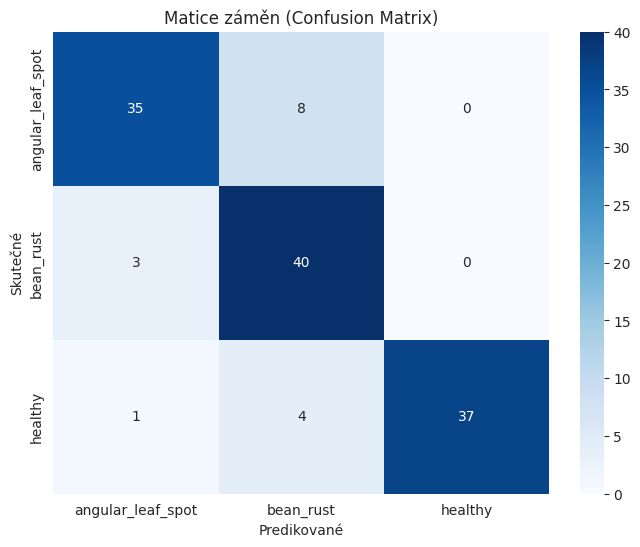

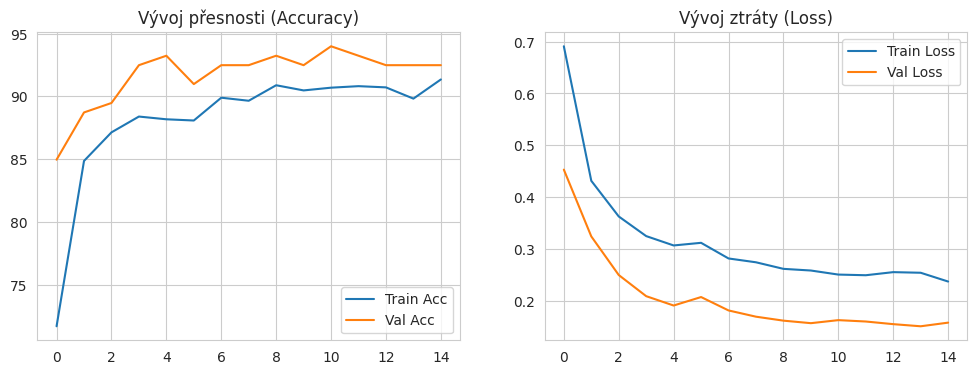

In [ ]:
# preprocesing + pretrained model
plot_confusion_matrix(model_3, test_loader)
plot_history(history_3)

# vlastní závěry

In [ ]:
arch_vAc_tAc_tLoss_table()

,Architektura,Val. Accuracy (%),Test Accuracy (%),Test Loss
0,Model 0,81.20,77.34,0.5775
1,Model 1,85.71,87.50,0.2807
2,Model 2,90.98,83.59,0.3579
3,Model 3,93.98,87.50,0.2820
